In [1]:
%matplotlib inline

import covid19_WebScrapes # contains functions to scrape various sources
import algosdk
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Read in Test Data

In [25]:
testing_scrape = covid19_WebScrapes.TestingData_Scraper()
Testing_DF = testing_scrape.Scrape_Stats()

# Read in Algorand Blockchain Survey Data

In [3]:
API_KEY=str(np.loadtxt('local_var.txt',dtype=str))[8:]

alg_tx = covid19_WebScrapes.Algorand_Scrape(API_KEY)

algod last round: 5867381
algod time since last round: 2783173063
algod catchup: 0
algod latest version: https://github.com/algorandfoundation/specs/tree/4a9db6a25595c6fd097cf9cc137cc83027787eaa
####################
{'hash': 'UKUFQJMV5QBYWYWIPCCO5EALBPSWFGCB6XQHRQL4MDK67FTSCQSA', 'previousBlockHash': 'L75QZMEXRWJWR4XIA7ALNY4S32Q4EGQBY6Z5HKPXSUQJ6MRBF7UQ', 'seed': 'OHKJPXXYO42Z6IW5L5KRLEC7F55LGGLKPAO4VSDUU6PPSSDHBGGQ', 'proposer': 'JJFGCPCZPYRLOUYBZVC4F7GRPZ5CLB6BMTVRGNDP7GRGXL6GG4JEN7DL54', 'round': 5867381, 'period': 0, 'txnRoot': 'WRS2VL2OQ5LPWBYLNBCZV3MEQ4DACSRDES6IUKHGOWYQERJRWC5A', 'reward': 114820, 'rate': 25999980, 'frac': 1953507633, 'txns': {}, 'timestamp': 1586025336, 'currentProtocol': 'https://github.com/algorandfoundation/specs/tree/4a9db6a25595c6fd097cf9cc137cc83027787eaa', 'nextProtocol': '', 'nextProtocolApprovals': 0, 'nextProtocolVoteBefore': 0, 'nextProtocolSwitchOn': 0, 'upgradePropose': '', 'upgradeApprove': False}

 total rounds: 221381
found 1147 transactions


In [4]:
headers = [
    
    'a',
    
    '_t',  
    '_v',  

    # general demographic data
    'gc',  # string, country code (see Location Data section below)
    'gr',  # string, region code  (see Location Data section below)
    'gzp', # string, 3-digit zip code (US only)
    'ga',  # integer, age group, if present must be in 1,11,21,31,41,51,56,61,66,71,76,81,85
    'gs',  # string , gender, if present must be 'm','f'

    # symptoms
    'sz',  # integer, is symptomatic, no-answer=0/no=-1/yes=1
    's1',  # boolean, fever
    's2',  # boolean, cough
    's3',  # boolean, difficulty breathing
    's4',  # boolean, fatigue
    's5',  # boolean, sore throat
    'sds', # date, when symptoms started, yyyy-mm-dd
    'sde', # date, when symptoms ended, yyyy-mm-dd
    'sdn', # boolean, still symptomatic

    #tested
    'tz',  # integer, tested, no-answer=0/no=-1/yes=1
    'tt',  # integer, tried to get tested, no=-1, yes=1, yes but was denied=2
    'td',  # date, test date, yyyy-mm-dd
    'tr',  # integer, test results, -1=negative,1=positive,2=waiting for result
    'tl',  #  integer, test location, 1=Dr office/2=Hospital/3=Urgent care/4=Ad-hoc center/5=Other

    # medical care
    'mz',  #  integer, received care, no-answer=0/no=-1/yes=1
    'm1',  #  boolean, doctor's office
    'm2',  #  boolean, walk-in clinic
    'm3',  #  boolean, virtual care
    'm4',  #  boolean, hospital/ER
    'm5',  #  boolean, other
    'mh',  #  integer, hospitalized, no-answer=0/no=-1/yes=1
    'mhs', #  date, when admitted, yyyy-mm-dd
    'mhe', #  date, when discharged, yyyy-mm-dd
    'mhn', #  boolean, still in hospital

    # quarantine
    'qz',  # integer, was quarantined, no-answer=0/no=-1/yes=1
    'q1',  # boolean, due to symptoms
    'q2',  # boolean, voluntarily
    'q3',  # boolean, personally required
    'q4',  # boolean, general quarantine
    'qds', # date, when quarantine started, yyyy-mm-dd
    'qde', # date, when quarantine ended, yyyy-mm-dd
    'qdn', # boolean, still quarantined
    'ql',  # integer, left quarantine temporarily no-answer=0/no=-1/yes=1

    'consent' # boolean' , user's consent, mandatory, must be 'true'
]

In [5]:
alg_txs = alg_tx.get_txns()

Survey_DF = pd.DataFrame()

###### DECODING DATA
for i in range(len(alg_txs)):
    #if (i%1000 == 0): print("{} transactions decoded".format(i))
    tx_dict = alg_txs[i]
    tx_code = tx_dict['tx']
    encoded_note = tx_dict['noteb64']
    decoded_note = algosdk.encoding.msgpack.unpackb(algosdk.encoding.base64.b64decode(encoded_note))
    decoded_note = decoded_note[b'd']
    decoded_note_data = {
        key.decode() if isinstance(key, bytes) else key:
        val.decode() if isinstance(val, bytes) else val
        for key, val in decoded_note.items()
    }
    decoded_note_data.update({'a':tx_code})
    cleaned_note_data = {key:None for key in headers}
    cleaned_note_data.update(decoded_note_data)
    #print(cleaned_note_data)
    Survey_DF = Survey_DF.append(cleaned_note_data, ignore_index=True)

In [6]:
Survey_DF_trim = Survey_DF[['gc','gr','gzp','ga','gs','sz','tz','tt','tr','mz','qz','q1','q2','q3','q4','ql']]
Survey_DF_trim.columns = ['Country','Region','Zip','AgeGroup','Gender','Symptomatic',
                          'Tested','Tested_Attempt','Test_Result','Received_Care','Quarantined',
                          'Q_Symptoms','Q_Voluntary','Q_Personal','Q_General','Left_Quarantine']
Survey_DF_trim.head()

,Country,Region,Zip,AgeGroup,Gender,Symptomatic,Tested,Tested_Attempt,Test_Result,Received_Care,Quarantined,Q_Symptoms,Q_Voluntary,Q_Personal,Q_General,Left_Quarantine
0,US,NY,100,55,f,-1,-1,-1,None,-1,1,None,1,None,None,1
1,AU,ACT,None,40,m,-1,-1,-1,None,-1,-1,None,None,None,None,None
2,US,None,100,65,m,-1,1,None,-1,-1,1,True,None,None,None,-1
3,US,NY,104,40,f,-1,-1,-1,None,-1,-1,None,None,None,None,None
4,US,MD,207,20,m,-1,-1,-1,None,-1,-1,None,None,None,None,None


# Read in Wikipedia Area Data

In [7]:
wiki_scraper = covid19_WebScrapes.Wiki_Scrape()

county_areas = wiki_scraper.Scrape_Counties()

Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia_(U.S._state),Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New_Hampshire,New_Jersey,New_Mexico,New_York,North_Carolina,North_Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode_Island,South_Carolina,South_Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West_Virginia,Wisconsin,Wyoming,

In [8]:
County_Areas = pd.DataFrame(county_areas,columns=['State','County','Area (sqmi)'])

In [9]:
County_Areas['Area (sqmi)'] = County_Areas['Area (sqmi)'] .apply(lambda x : str(x).replace(',',''))
County_Areas['Area (sqmi)'] = County_Areas['Area (sqmi)'].astype(float)

In [11]:
County_Areas.to_csv('data/County_Areas.csv',index=False)
Survey_DF.to_csv('data/Survey_Data_Blockchain.csv',index=False)

# Now data is read in, can assess

In [24]:
Testing_DF.head()

""


In [22]:
Testing_DF = Testing_DF.reset_index(drop=True)
Testing_DF['Date'] = Testing_DF['Date'].apply(lambda  x : datetime.datetime.strptime(x,'%d %b %Y %a').strftime('%m/%d/%y'))

Testing_DF = Testing_DF.replace({'':0})
for col in Testing_DF.columns[1:-1] :
    Testing_DF[col] = Testing_DF[col].apply(lambda x : str(x).replace(',',''))
    Testing_DF[col] = Testing_DF[col].astype(int)


KeyError: 'Date'

In [23]:
## Generate new features :

Testing_DF['Percent_Positive'] = Testing_DF['Positive']/Testing_DF['Total']
Testing_DF['Death_Rate'] = Testing_DF['Deaths']/Testing_DF['Positive']
Testing_DF['Percent_Positive'] = Testing_DF['Percent_Positive'].fillna(0)
Testing_DF['Death_Rate'] = Testing_DF['Death_Rate'].fillna(0)

Testing_DF.head()

KeyError: 'Positive'

In [ ]:
date_mapping = dict(zip(list(Testing_DF['Date'].unique()),reversed(range(len(set(Testing_DF['Date']))))))
Testing_DF['Days_Since_First_Case'] = Testing_DF['Date'].map(date_mapping)

In [20]:
plt.figure(figsize=(25,10))
for state in Testing_DF['State'].unique() :
    subbed = Testing_DF[Testing_DF['State'] == state]
    #dates_xaxis = subbed['Date'].apply(lambda  x : datetime.datetime.strptime(x,'%m/%d/%y'))
    dates_xaxis = subbed['Days_Since_First_Case']
    plt.plot(dates_xaxis,subbed['Positive'])
plt.yscale('log')
plt.legend(Testing_DF['State'].unique(),loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)
plt.xlabel('Days_Since_First_Case')
plt.ylabel('Confirmed Cases (log10)')
plt.ylim(100,max(Testing_DF['Positive']))
plt.show()

KeyError: 'State'

<Figure size 1800x720 with 0 Axes>

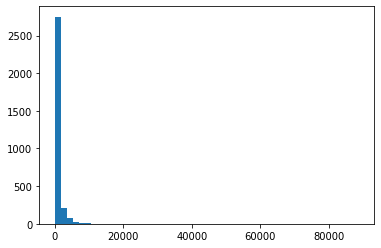

In [18]:
County_Areas = County_Areas[County_Areas['County'] != 'Unorganized Borough']

plt.hist(County_Areas['Area (sqmi)'],bins=50)
plt.show()

# Work with distance (proximity) logic

In [136]:
time_series = pd.read_csv('data/time_series_covid19_confirmed_US.csv')
population = pd.read_csv('data/US_County_Population.txt',sep='\t')
population = population[['Geographic Area','Census','2019']]

In [137]:
split_area = population['Geographic Area'].apply(lambda x: x.split(',')).to_list()
population['County'] = np.array(split_area)[:,0]
population['State'] = [val.strip() for val in np.array(split_area)[:,1]]
population.drop('Geographic Area',axis=1,inplace=True)
population['County'] = population['County'].apply(lambda x : x.replace('.',''))
for col in ['Census','2019'] :
    population[col] = population[col].apply(lambda x : x.replace(',','')).astype(int)

In [138]:
population.sort_values('2019',ascending=False)

,Census,2019,County,State
204,9818605,10039107,Los Angeles County,California
610,5194675,5150233,Cook County,Illinois
2623,4092459,4713325,Harris County,Texas
103,3817117,4485414,Maricopa County,Arizona
222,3095313,3338330,San Diego County,California
...,...,...,...,...
1656,460,463,Arthur County,Nebraska
2653,416,404,Kenedy County,Texas
2657,286,272,King County,Texas
2673,82,169,Loving County,Texas


In [139]:
def Merge_NYC(df) :
    
    ind_nyc = []
    for i,row in df.iterrows() :
        county = row['County']
        state = row['State']
        if state != 'New York' :
            continue
        for name in ['Bronx','Brooklyn','Manhattan','Staten Island','Queens','New York'] :
            if name in county :
                ind_nyc.append(i)
    
    new_row = list(np.sum(df.loc[ind_nyc,['Census','2019']]).values)
    new_row.extend(['NYC','New York'])
    new_row = pd.DataFrame([new_row],columns=population.columns)
    df = df.append(new_row,ignore_index=True)
    
    return df.drop(ind_nyc)

In [142]:
out = Merge_NYC(population)

out.to_csv('data_cleaned/US_County_Population_Cleaned.csv')